In [0]:
# Import the machine learning libraries.
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(suppress=True, precision=1)

In [0]:
def env_step(s, a):
    s_ = s
    if a == 0: #N
        if s[0] > 0:
            s_ = (s[0]-1, s[1])
    elif a == 1: #S
        if s[0] < 3:
            s_ = (s[0]+1, s[1])
    elif a == 2: #E
        if s[1] < 11:
            s_ = (s[0], s[1]+1)
    elif a == 3: #W
        if s[1] > 0:
            s_ = (s[0], s[1]-1)
    else:
        raise ValueError("a must be between 0 and 3 inclusive, but is {}".format(a))
        
    done = False
    if s_ == (3, 11):
        r = -1
        done = True
    elif s_[0] == 3 and 0 < s_[1]:
        r = -100
        s_ = (3, 0) # back to start
    else:
        r = -1
    
    return s_, r, done


def episodic_td_0_control(Pi, on_policy, ep_decay=False, debug=False):
    alpha=0.1
    gamma=1
    epsilon=0.1
    E=550
    Q = np.zeros((4,12,4))
    max_steps = 100
    rewards = []
    for i in range(E):
        if ep_decay:
            epsilon = epsilon * 0.99
        s = (3, 0)
        reward = 0
        if on_policy:
            a_ = Pi(Q, s, epsilon) 
        for j in range(max_steps):
            if on_policy:
                a = a_
            else:
                a = Pi(Q, s, epsilon)
            s_, r, done = env_step(s, a)
            if debug:
                print(Q[s], Q[s_])
                print(s, a, r, s_)
            reward += r
            if on_policy:
                a_ = Pi(Q, s_, epsilon)
            else:
                a_ = Pi(Q, s_, 0)
            Q[s[0], s[1], a] = (1 - alpha)*Q[s[0], s[1], a] + alpha*(r + gamma*Q[s_[0], s_[1], a_])
            if debug:
                print(Q[s])
            s = s_
            if done:
                break
        
        if debug:
            print(reward)
        rewards.append(reward)
        
    return Q, rewards


def epsilon_greedy(Q, s, epsilon):
    if np.random.rand() < epsilon:
        a = np.random.randint(0,4)
    else:
        a_s = np.argwhere(Q[s] == np.max(Q[s]))
        a = np.random.choice(a_s.flatten())
        
    return a


def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N


def a_to_char(a):
    if a == 0:
        return 'N'
    elif a == 1:
        return 'S'
    elif a == 2:
        return 'E'
    elif a == 3:
        return 'W'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  # Remove the CWD from sys.path while we load stuff.


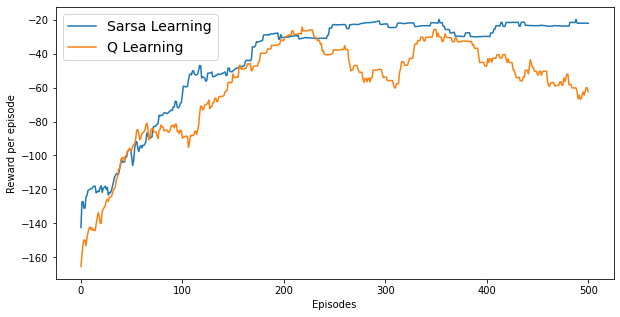

In [14]:
fig = plt.figure(figsize=(10, 5))
on_policy_V, on_policy_rewards = episodic_td_0_control(epsilon_greedy, on_policy=True)
plt.plot(running_mean(on_policy_rewards, 50))

off_policy_V, off_policy_rewards = episodic_td_0_control(epsilon_greedy, on_policy=False)
plt.plot(running_mean(off_policy_rewards, 50))

plt.ylabel("Reward per episode")
plt.xlabel("Episodes")
plt.legend(['Sarsa Learning', 'Q Learning'], loc='bottom right', fontsize=14)
plt.show()